### Use LeNet to get a 84 dim embedding 

In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.


(32 conv 5x5 -> 
PReLU -> 
MaxPool 2x2 -> 
64 conv 5x5 -> 
PReLU -> 
MaxPool 2x2 -> 
Dense 256 -> 
PReLU -> 
Dense 256 -> 
PReLU -> 
Dense 2) 

For different datasets we use a network with different number of input channels eg. MNIST or SVHN

<img src="./images/siamese.png" height="422" width="722" >

Contrastive loss function is given by the following :-

$$\mathcal{L}(I_{1}, I_{2}) = y[\mathcal{E}_{I_{1}}-\mathcal{E}_{I_{2}}]^{2} + (1-y)*ReLU([\mathcal{m}-[\mathcal{E}_{I_{1}}-\mathcal{E}_{I_{2}}]]^{2})$$

where $\mathcal{E}$ is the final layer embedding of the neural network, $\mathcal{I_{1}}$ is the example from primary domain, $\mathcal{I_{2}}$ is the example from helper domain.  

In [2]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# tNSE embeddings from the penultimate layer of LeNet
from sklearn.manifold import TSNE

In [3]:
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset, checkAndCreateFolder, getChannels

# Set up data loaders
from datasets import SiameseCD,SiameseMNIST,SiameseSVHN

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet, LeNet
from losses import ContrastiveLoss

classes = [i for i in range(10)]
instances = [5000 for i in range(10)]


batch_size=128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [4]:
def showLossHist(lossHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(lossHist['trainLoss']))

    y1 = lossHist['trainLoss']
    y2 = lossHist['valLoss']

    plt.plot(x, y1, label='Training Loss')
    plt.plot(x, y2, label='Validation Loss')

    plt.xlabel('Epochs')
    plt.ylabel('Contrastive Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')

    plt.show()

In [5]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(primary_embeddings, primary_targets, helper_embeddings, helper_targets):
    
    plt.figure(figsize=(10,10))
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    
    for i in range(10):
        
        primary_inds = np.where(primary_targets==i)[0]      
        #primary_tsne = tsne.fit_transform(primary_embeddings[primary_inds])
        #plt.scatter(primary_tsne[:, 0], primary_tsne[:, 1],  marker=(4,0,0), alpha=0.3, color=colors[i], s=100)
        plt.scatter(primary_embeddings[primary_inds,0], primary_embeddings[primary_inds,1],  marker=(4,0,0), alpha=0.3, color=colors[i], s=100)

        helper_inds = np.where(helper_targets==i)[0]        
        #helper_tsne = tsne.fit_transform(helper_embeddings[helper_inds])
        #plt.scatter(helper_tsne[:, 0], helper_tsne[:, 1],  marker='o', alpha=0.3, color=colors[i], s=100)
        plt.scatter(helper_embeddings[helper_inds,0], helper_embeddings[helper_inds,1],  marker='o', alpha=0.3, color=colors[i], s=100)


    #plt.legend(mnist_classes)

def extract_embeddings(dataloader, model, domain='primary'):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 2))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images, domain).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

In [6]:
primaryDataset = 'MNIST'
helperDataset = 'SVHN'

# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset(primaryDataset, classes, instances,'train')
train_dataset_helper = loadDataset(helperDataset, classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset(primaryDataset, classes, instances,'test')
test_dataset_helper = loadDataset(helperDataset, classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

siamese_train_dataset=SiameseCD(train_dataset_primary, train_dataset_helper)
siamese_test_dataset=SiameseCD(test_dataset_primary, test_dataset_helper)

siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [7]:
margin = 1.
embedding_net_primary = LeNet(getChannels(primaryDataset))
embedding_net_helper = LeNet(getChannels(helperDataset))

model = SiameseNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

modelFolderName = 'models'

Train: [0/50000 (0%)]	Loss: 0.227619
Train: [12800/50000 (26%)]	Loss: 0.125657
Train: [25600/50000 (51%)]	Loss: 0.125250
Train: [38400/50000 (77%)]	Loss: 0.125147
Epoch: 1/20. Train set: Average loss: 0.1256
Epoch: 1/20. Validation set: Average loss: 0.1252
Train: [0/50000 (0%)]	Loss: 0.126657
Train: [12800/50000 (26%)]	Loss: 0.125137
Train: [25600/50000 (51%)]	Loss: 0.125215
Train: [38400/50000 (77%)]	Loss: 0.125077
Epoch: 2/20. Train set: Average loss: 0.1251
Epoch: 2/20. Validation set: Average loss: 0.1250
Train: [0/50000 (0%)]	Loss: 0.126157
Train: [12800/50000 (26%)]	Loss: 0.125133
Train: [25600/50000 (51%)]	Loss: 0.125126
Train: [38400/50000 (77%)]	Loss: 0.125040
Epoch: 3/20. Train set: Average loss: 0.1251
Epoch: 3/20. Validation set: Average loss: 0.1253
Train: [0/50000 (0%)]	Loss: 0.126335
Train: [12800/50000 (26%)]	Loss: 0.125101
Train: [25600/50000 (51%)]	Loss: 0.125112
Train: [38400/50000 (77%)]	Loss: 0.125049
Epoch: 4/20. Train set: Average loss: 0.1251
Epoch: 4/20. Valid

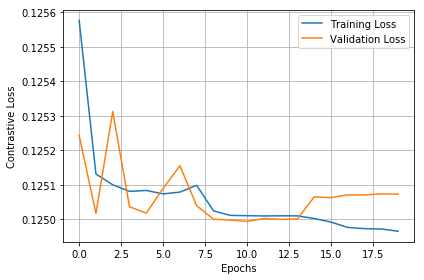

In [8]:
lossDict = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

checkAndCreateFolder(modelFolderName)
modelFileName = primaryDataset + '_' + helperDataset + '_' + 'contrastive' + '.pt'
PATH = modelFolderName + '/' + modelFileName
torch.save(model.state_dict(), PATH)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.033s...
[t-SNE] Computed neighbors for 5000 samples in 3.749s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.014530
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.067131
[t-SNE] Error after 300 iterations: 2.205179
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4948 samples in 0.031s...
[t-SNE] Computed neighbors for 4948 samples in 2.593s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4948
[t-SNE] Computed conditional probabilities for sample 2000 / 4948
[t-SNE] Computed conditional probabilities for sample 3000 / 4948
[t-SNE] Computed conditional probabi

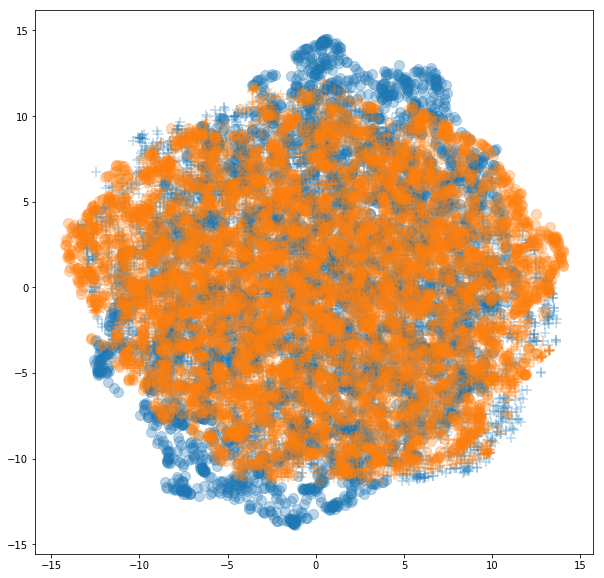

In [9]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, 'primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, 'helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 980 samples in 0.002s...
[t-SNE] Computed neighbors for 980 samples in 0.276s...
[t-SNE] Computed conditional probabilities for sample 980 / 980
[t-SNE] Mean sigma: 0.019802
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.613483
[t-SNE] Error after 300 iterations: 1.102659
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1744 samples in 0.004s...
[t-SNE] Computed neighbors for 1744 samples in 0.423s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1744
[t-SNE] Computed conditional probabilities for sample 1744 / 1744
[t-SNE] Mean sigma: 0.060102
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.309906
[t-SNE] Error after 300 iterations: 1.253576
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1135 samples in 0.002s...
[t-SNE] Computed neighbors for 1135 samples in 0.361s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1135
[t-SNE] Co

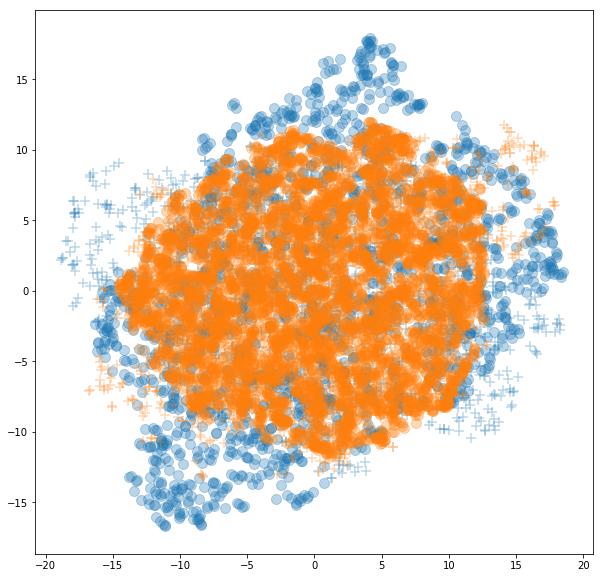

In [10]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model, 'primary')
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model, 'helper')


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

2 dimensional embedding 

Train: [0/50000 (0%)]	Loss: 0.196620
Train: [12800/50000 (26%)]	Loss: 0.126972
Train: [25600/50000 (51%)]	Loss: 0.125994
Train: [38400/50000 (77%)]	Loss: 0.125528
Epoch: 1/20. Train set: Average loss: 0.1262
Epoch: 1/20. Validation set: Average loss: 0.1252
Train: [0/50000 (0%)]	Loss: 0.124936
Train: [12800/50000 (26%)]	Loss: 0.125467
Train: [25600/50000 (51%)]	Loss: 0.125337
Train: [38400/50000 (77%)]	Loss: 0.125258
Epoch: 2/20. Train set: Average loss: 0.1253
Epoch: 2/20. Validation set: Average loss: 0.1251
Train: [0/50000 (0%)]	Loss: 0.124761
Train: [12800/50000 (26%)]	Loss: 0.125156
Train: [25600/50000 (51%)]	Loss: 0.125231
Train: [38400/50000 (77%)]	Loss: 0.125086
Epoch: 3/20. Train set: Average loss: 0.1252
Epoch: 3/20. Validation set: Average loss: 0.1250
Train: [0/50000 (0%)]	Loss: 0.124979
Train: [12800/50000 (26%)]	Loss: 0.125154
Train: [25600/50000 (51%)]	Loss: 0.125209
Train: [38400/50000 (77%)]	Loss: 0.125144
Epoch: 4/20. Train set: Average loss: 0.1251
Epoch: 4/20. Valid

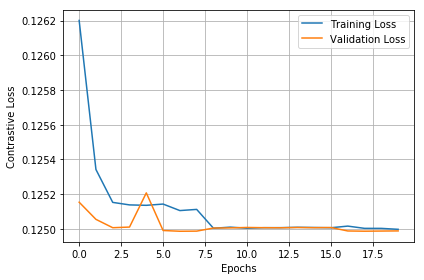

In [15]:
lossDict = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

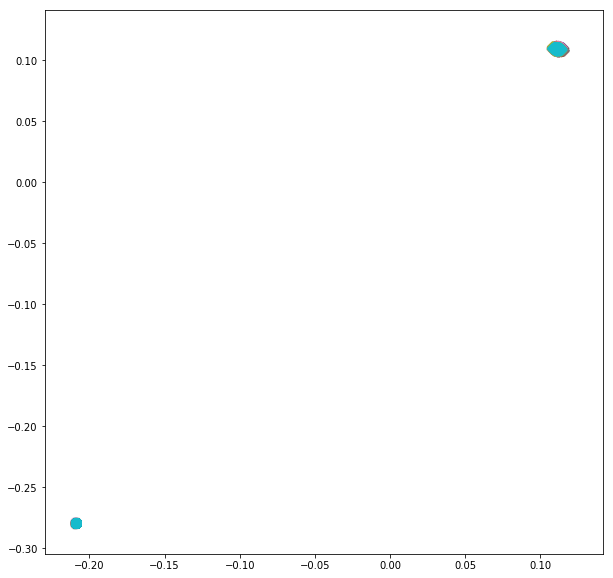

In [18]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, 'primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, 'helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

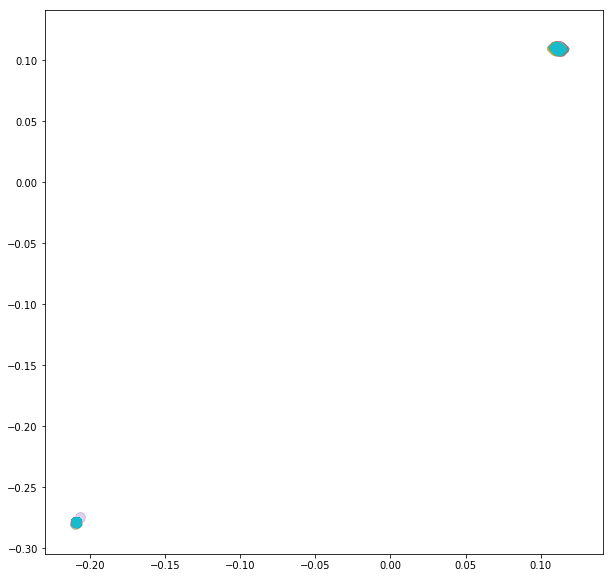

In [19]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model, 'primary')
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model, 'helper')


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

### Conducting the same experiments for 'USPS'

In [9]:
primaryDataset = 'MNIST'
helperDataset = 'USPS'

# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset(primaryDataset, classes, instances,'train')
train_dataset_helper = loadDataset(helperDataset, classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset(primaryDataset, classes, instances,'test')
test_dataset_helper = loadDataset(helperDataset, classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

siamese_train_dataset=SiameseCD(train_dataset_primary, train_dataset_helper)
siamese_test_dataset=SiameseCD(test_dataset_primary, test_dataset_helper)


siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [10]:
margin = 1.
embedding_net_primary = LeNet(getChannels(primaryDataset))
embedding_net_helper = LeNet(getChannels(helperDataset))

model = SiameseNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

modelFoldername = 'models'

Train: [0/50000 (0%)]	Loss: 0.177924
Train: [12800/50000 (26%)]	Loss: 0.100618
Train: [25600/50000 (51%)]	Loss: 0.055552
Train: [38400/50000 (77%)]	Loss: 0.040259
Epoch: 1/20. Train set: Average loss: 0.0583
Epoch: 1/20. Validation set: Average loss: 0.0293
Train: [0/50000 (0%)]	Loss: 0.029572
Train: [12800/50000 (26%)]	Loss: 0.027537
Train: [25600/50000 (51%)]	Loss: 0.025921
Train: [38400/50000 (77%)]	Loss: 0.022749
Epoch: 2/20. Train set: Average loss: 0.0245
Epoch: 2/20. Validation set: Average loss: 0.0214
Train: [0/50000 (0%)]	Loss: 0.016875
Train: [12800/50000 (26%)]	Loss: 0.019380
Train: [25600/50000 (51%)]	Loss: 0.018429
Train: [38400/50000 (77%)]	Loss: 0.017825
Epoch: 3/20. Train set: Average loss: 0.0182
Epoch: 3/20. Validation set: Average loss: 0.0182
Train: [0/50000 (0%)]	Loss: 0.013982
Train: [12800/50000 (26%)]	Loss: 0.016379
Train: [25600/50000 (51%)]	Loss: 0.014967
Train: [38400/50000 (77%)]	Loss: 0.013943
Epoch: 4/20. Train set: Average loss: 0.0148
Epoch: 4/20. Valid

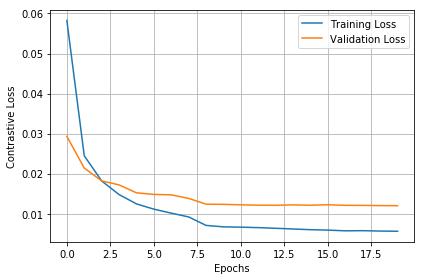

In [11]:
lossDict = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

checkAndCreateFolder(modelFolderName)
modelFileName = primaryDataset + '_' + helperDataset + '_' + 'contrastive' + '.pt'
PATH = modelFolderName + '/' + modelFileName
torch.save(model.state_dict(), PATH)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 2.145s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.012010
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.405457
[t-SNE] Error after 300 iterations: 2.261551
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 767 samples in 0.001s...
[t-SNE] Computed neighbors for 767 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 767 / 767
[t-SNE] Mean sigma: 0.016247
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.055252
[t-SNE] Error after 300 iterations: 0.990747
[t-SNE] Computing 12

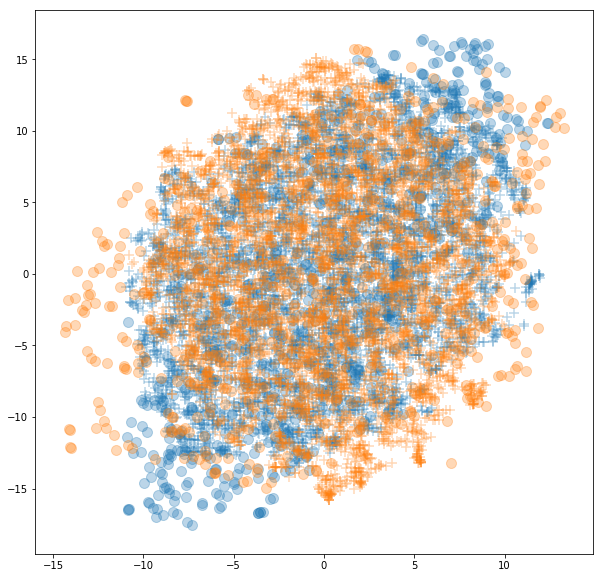

In [14]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 980 samples in 0.002s...
[t-SNE] Computed neighbors for 980 samples in 0.139s...
[t-SNE] Computed conditional probabilities for sample 980 / 980
[t-SNE] Mean sigma: 0.017240
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.867374
[t-SNE] Error after 300 iterations: 1.135845
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 786 samples in 0.001s...
[t-SNE] Computed neighbors for 786 samples in 0.097s...
[t-SNE] Computed conditional probabilities for sample 786 / 786
[t-SNE] Mean sigma: 0.020028
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.886944
[t-SNE] Error after 300 iterations: 0.879347
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1135 samples in 0.002s...
[t-SNE] Computed neighbors for 1135 samples in 0.179s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1135
[t-SNE] Computed conditional probabilities for sample 1135 / 1135
[t-SNE] Mean s

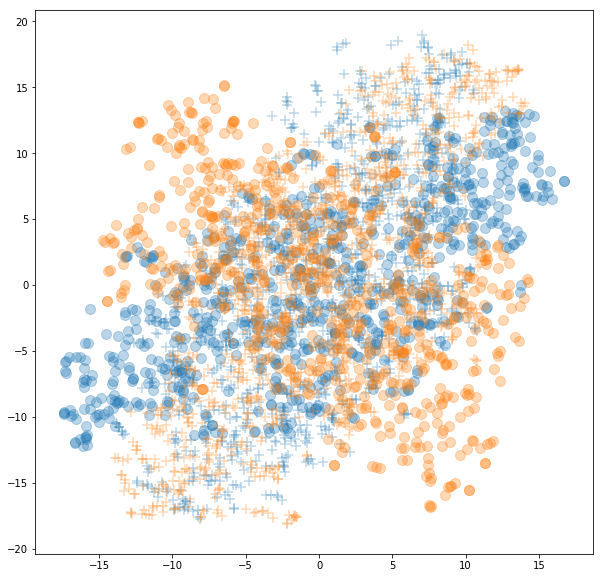

In [15]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model, domain='primary')
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model, domain='helper')


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

2 dimensional embedding 

Train: [0/50000 (0%)]	Loss: 0.183217
Train: [12800/50000 (26%)]	Loss: 0.119441
Train: [25600/50000 (51%)]	Loss: 0.089108
Train: [38400/50000 (77%)]	Loss: 0.078261
Epoch: 1/20. Train set: Average loss: 0.0900
Epoch: 1/20. Validation set: Average loss: 0.0693
Train: [0/50000 (0%)]	Loss: 0.058871
Train: [12800/50000 (26%)]	Loss: 0.064452
Train: [25600/50000 (51%)]	Loss: 0.052696
Train: [38400/50000 (77%)]	Loss: 0.046121
Epoch: 2/20. Train set: Average loss: 0.0512
Epoch: 2/20. Validation set: Average loss: 0.0395
Train: [0/50000 (0%)]	Loss: 0.028912
Train: [12800/50000 (26%)]	Loss: 0.036549
Train: [25600/50000 (51%)]	Loss: 0.034320
Train: [38400/50000 (77%)]	Loss: 0.033128
Epoch: 3/20. Train set: Average loss: 0.0337
Epoch: 3/20. Validation set: Average loss: 0.0323
Train: [0/50000 (0%)]	Loss: 0.030687
Train: [12800/50000 (26%)]	Loss: 0.030022
Train: [25600/50000 (51%)]	Loss: 0.028637
Train: [38400/50000 (77%)]	Loss: 0.027735
Epoch: 4/20. Train set: Average loss: 0.0283
Epoch: 4/20. Valid

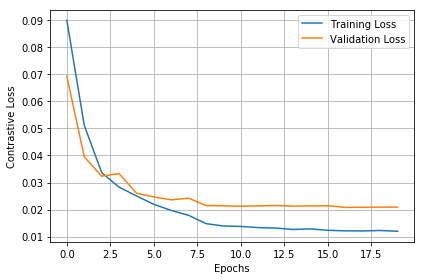

In [22]:
lossDict = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)
showLossHist(lossDict)

checkAndCreateFolder(modelFolderName)
modelFileName = primaryDataset + '_' + helperDataset + '_' + 'contrastive' + '.pt'
PATH = modelFolderName + '/' + modelFileName
torch.save(model.state_dict(), PATH)

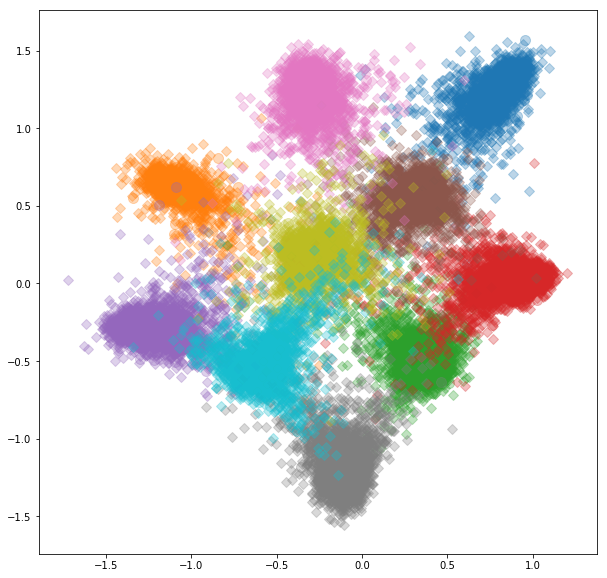

In [23]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, 'primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, 'helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

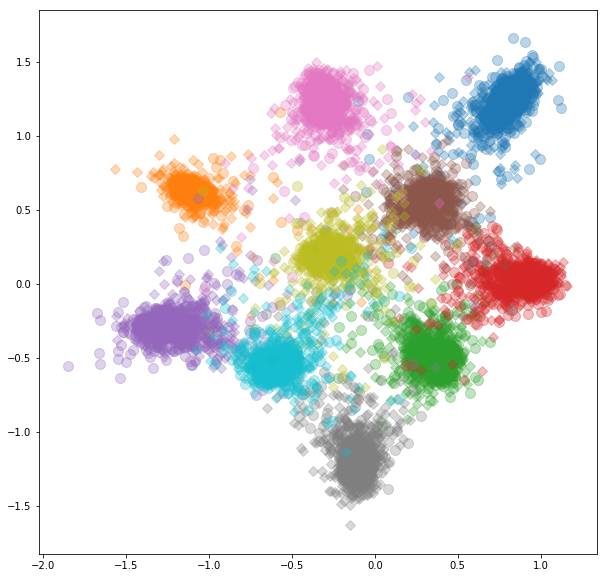

In [24]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model, domain='primary')
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model, domain='helper')


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

### Online Pair Selection 

 We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.

In [ ]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, AllPositivePairSelector(balance=True))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)